In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape) 

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/tmp/ipykernel_26980/1799943160.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [5]:
batch_size = 128
latent_d = 128
neurons = 512
out_shape = (-1, 28, 28) #You could also do (-1, 1, 28, 28) for 1 channel, but that makes numpy code a little more cumbersome later
num_epochs = 10

def fcLayer(in_neurons, out_neurons, leak=0.1): #our helper function
    """
    in_neurons: how many inputs to this layer
    out_neurons: how many outputs for this layer
    leak: the leaky relu leak value. 
    """
    return nn.Sequential(
        nn.Linear(in_neurons, out_neurons),
        nn.LeakyReLU(leak),
        nn.LayerNorm(out_neurons)
    )

In [6]:
def simpleGAN(latent_d, neurons, out_shape, sigmoidG=False, leak=0.2):
    """
    This function will create a simple GAN for us to train. It will return a 
    tuple (G, D), holding the generator and discriminator network respectively. 
    
    latent_d: the number of latent variables we will use as input to the generator G. 
    neurons: how many hidden neurons to use in each hidden layer
    out_shape: the shape of the output of the discriminator D. This should be the 
    same shape as the real data. 
    sigmoidG: true if the generator G should end with a sigmoid activation, or 
    False if it should just return unbounded activations
    """
    G = nn.Sequential(
        fcLayer(latent_d, neurons, leak),
        fcLayer(neurons, neurons, leak),
        fcLayer(neurons, neurons, leak),
        fcLayer(neurons, neurons, leak),
        nn.Linear(neurons, abs(np.prod(out_shape)) ),# np.prod will multiply each value together in the shape, giving us the total number of needed outputs. abs will remove the impact of "-1" for the batch dimension.
        View(out_shape)#Now re-shape the output to whatever D expects. 
    )
    #Sometimes we do/don't want G to return a sigmoid value (i.e., [0,1]), so we wrap it in an a conditional
    if sigmoidG:
        G = nn.Sequential(G, nn.Sigmoid())
    
    D = nn.Sequential(
        nn.Flatten(),
        fcLayer(abs(np.prod(out_shape)), neurons, leak),
        fcLayer(neurons, neurons, leak),
        fcLayer(neurons, neurons, leak),
        fcLayer(neurons, neurons, leak),
        nn.Linear(neurons, 1 ) #D has 1 output for a binary classification problem
    )
    return G, D
G, D = simpleGAN(latent_d, neurons, out_shape, sigmoidG=True)

In [8]:
G.to(device)
D.to(device)

# Initialize BCEWithLogitsLoss function. The BCE loss is for binary classification problems, which ours is (real vs fake)
loss_func = nn.BCEWithLogitsLoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0.0, 0.9))

In [9]:
train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [10]:
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    print(epoch)
    for data, class_label in train_loader:
        # prep batch & make labels
        real_data = data.to(device)
        y_real = torch.full((batch_size,1), real_label, dtype=torch.float32, device=device)
        y_fake = torch.full((batch_size,1), fake_label, dtype=torch.float32, device=device)
        
        # Step 1) $\ell ( D( x_{\mathit{real}}) ,\ y_{\mathit{real}})\$ and $\ell ( D(\boldsymbol{x}_{\mathit{fake}}) ,\ y_{\mathit{fake}})$
        D.zero_grad()

        # Calculate loss on all-real batch
        errD_real = loss_func(D(real_data), y_real)
        # Calculate gradients for D in backward pass
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors $z \sim \mathcal{N}(\vec{0}, 1)$
        z = torch.randn(batch_size, latent_d, device=device)
        # Generate fake image batch with G
        # Classify all fake batch with D. We will save this to re-use for the 2nd step. 
        fake = G(z) 
        #Why do we detach here? Because we don't want the gradient to impact G. 
        #Our goal right now is to update _just_ the discriminator. 
        #BUT, we will re-use this fake data for updating the discriminator, so we want to save the 
        #non-detached version! 
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_func(D(fake.detach()), y_fake)
        # Calculate the gradients for this batch
        errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Step 2) $\ell ( D(\boldsymbol{x}_{\mathit{fake}}) ,\ y_{\mathit{real}})$
        G.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # Calculate G's loss based on this output
        errG = loss_func(D(fake), y_real)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

0
1
2
3
4
5
6
7
8
9


In [11]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_d, device=device) #$\boldsymbol{z} \sim \mathcal{N}(\vec{0}, \boldsymbol{I})$
    fake_digits = G(noise) 
    scores = torch.sigmoid(D(fake_digits))
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()

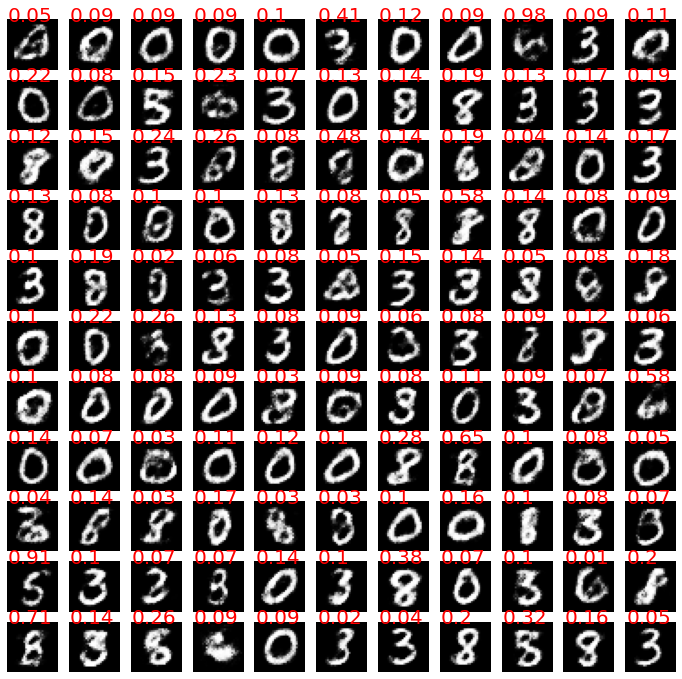

In [19]:
def plot_gen_imgs(fake_digits, scores=None):
    batch_size = fake_digits.size(0)
    #This code assumes we are working with black-and-white images
    fake_digits = fake_digits.reshape(-1, fake_digits.size(-1), fake_digits.size(-1))
    i_max = int(round(np.sqrt(batch_size)))
    j_max = int(np.floor(batch_size/float(i_max)))
    f, axarr = plt.subplots(i_max,j_max, figsize=(12,12))
    for i in range(i_max):
        for j in range(j_max):
            indx = i*j_max+j
            axarr[i,j].imshow(fake_digits[indx,:].numpy(), cmap='gray', vmin=0, vmax=1)
            axarr[i,j].set_axis_off()
            if scores is not None:
                axarr[i,j].text(0.0, 0.5, str(round(scores[indx],2)), dict(size=20, color='red'))
plot_gen_imgs(fake_digits, scores)

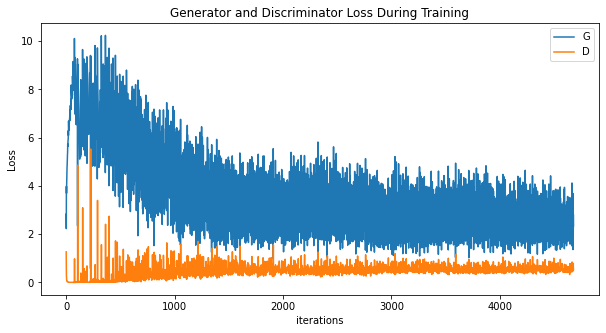

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()